### Evaluating supervised learning algorithms in graphene-to-phoneme transcription

Because English has had so much influence from other languages, e.g. from North Germanic languages and later after the Norman Conquest from Romance languages such as French and Latin, it is impossible to know for certain how to pronounce a specific word if you have only read it, espcecially if you do not know its etymology. It is interesting to see if a supervised machine learning algorithm can make reliable predictions to how words are pronounced without access to information outside of relationships between graphemes and how they correspond to phonemes in the training data. This can have real-world implications for example in text-to-speech synthesis.

Questions:
1. How suitable are Hidden Markov Models for this particular problem compared to n-gram taggers and a majority baseline tagger that naively assumes all variables to be independent?
2. What kinds of hidden structures can be uneartherd by different feature extractions?

In [91]:
# If you want to plot graphics in your notebook, keep this %matplotlib command here before your imports
%matplotlib notebook

# Import some necessary modules
import nltk, re, random
from nltk.corpus import cmudict
from nltk.tag import hmm
from sklearn.model_selection import train_test_split

# Arpabet phoneme set used in the CMU dictionary:
# 'AA', 'AH', 'AW', 'B', 'D', 'EH', 'EY', 'G', 'IH', 'JH', 'L', 'N', 'OW', 'P',
# 'S', 'T', 'UH', 'V', 'Y', 'ZH', 'AE', 'AO', 'AY', 'CH', 'DH', 'ER', 'F', 'HH',
# 'IY', 'K', 'M', 'NG', 'OY', 'R', 'SH', 'TH', 'UW', 'W', 'Z'

The program is a grapheme to phoneme transcriber that will predict the most likely pronunciation for a given word. For the purposes of this experiment, it is only tested as a machine learning task, but a user interface where it would give pronunciation from user input of words could easily be implemented. This program could also be used, e.g., as a part of a simple concatenative speech synthesizer.

I am using the CMU pronouncing dictionary as my data. First, I will separate training and testing sets – taking 90% for training and 10% for testing – by picking every 10th item from the dictionary for the test set. After splitting the data, I will randomly shuffle the training set and select 10% of the training set for an evaluation set. The separation of an evaluation set and a test set is for tweaking the algorithm and for preserving the integrity of the test set.

As pronunciation is a temporal problem, a sequence based approach should work well. Also, as pronunciation cannot be derived from e.g. suffixes or prefixes, a contextual machine learning approach that looks at a sequence and predicts the next label should give better results than e.g. rules-based systems.

I will be using three different supervised ML applications to approach my problem:

1. A majority baseline approach where the tagger assigns every grapheme with its most likely phoneme.

2. N-gram taggers which look at n-number of previous tags to choose the current tag. It is a greedy model in that it chooses every tag separately in a sequence, and when it has made a decision, it cannot change it. By adding cutoff (the tagger needs to see a minimun instances of a given context to use it), and backoff (if the current n-gram tagger cannot assign a tag, it backs off to lower level n-grams and finally to a default tagger), I expect the results to improve.

3. A Hidden Markov Model that takes the Markov assumption that "the next state depends only on the current state and is independent of previous history." This is very promising from the point of view of pronunciation, as (at least intuitively) it seems that the preceding sound would affect the current sound the most. An HMM works similar to a bigram tagger, as it calculates transition probabilities based on two tags, but unlike an n-gram tagger, an HMM is not greedy; instead it looks at all the possibilities for the whole sequence and chooses the most likely outcome. In essence it can change its mind after assigning a tag unlike an n-gram tagger.

In [92]:
tagged_vocabulary = nltk.corpus.cmudict.entries() # Uploads the data as tuples of words and their phonetic
                                                  # transcriptions.
cleared_vocabulary = []

for word, phones in tagged_vocabulary:
    phones_2 = []
    for phone in phones:
        phone = re.sub(r'[0-9]', "", phone) # To simplify the task I decided to leave out stress
        phones_2.append(phone)
    item = (word, phones_2)
    cleared_vocabulary.append(item) 
final_vocabulary = []
for x,y in cleared_vocabulary:
    if len(y) == len(x): # Also, for simplicity's sake I only included words
                         # that have as many graphemes as there are phonemes.
        item = (list(x), y)
        final_vocabulary.append(item)
graph_phon = []
for i,x in final_vocabulary:
    merged_list = tuple(zip(i, x))
    graph_phon.append(merged_list)

"""Training and test sets are split by taking every tenth word from the vocabulary
to the test_set, resulting in a test_set 11% the size of the training set. This ensures
that the sets represent the whole data."""

test_set = graph_phon[0::10]
del graph_phon[0::10]
train_set = graph_phon

"""Split training and evaluation sets"""
random.shuffle(train_set)
split = int(len(train_set)*0.9)
evaluation_set = train_set[split:]
train_set = train_set[:split]

Next, I will make sure the individual data sets are representative of the whole data by checking they all have a corresponding relative frequency of different phoneme tags:

In [93]:
"""CODE FOR SHOWING THE SPREAD Of TAGS IN DIFFERENT CATEGORIES"""
import itertools
from nltk import FreqDist

pre_phon_train = [[y for x,y in item] for item in train_set] #extract phoneme tags from sets
phon_train = list(itertools.chain.from_iterable(pre_phon_train)) #make a flat list of them

"""Do the same for all sets"""
pre_phon_eval = [[y for x,y in item] for item in evaluation_set]
phon_eval = list(itertools.chain.from_iterable(pre_phon_eval))
pre_phon_test = [[y for x,y in item] for item in test_set]
phon_test = list(itertools.chain.from_iterable(pre_phon_test))

"""Print 10 most common tags and their frequencies"""
t_dist = FreqDist(phon_train)
top_train = t_dist.most_common(10)

e_dist = FreqDist(phon_eval)
top_eval = e_dist.most_common(10)

test_dist = FreqDist(phon_test)
top_test = test_dist.most_common(10)

print("Frequencies of 10 most common phoneme tags in the datasets:\n\nTraining set\tEvaluation set\tTest set\n")

for (a,b,c) in zip(top_train, top_eval, top_test):
    print(a,b,c,"\n")

Frequencies of 10 most common phoneme tags in the datasets:

Training set	Evaluation set	Test set

('AH', 18989) ('AH', 2129) ('AH', 2286) 

('N', 14469) ('N', 1619) ('N', 1745) 

('S', 11446) ('T', 1236) ('S', 1460) 

('T', 11264) ('S', 1229) ('T', 1423) 

('R', 10911) ('R', 1213) ('R', 1345) 

('IH', 10645) ('L', 1194) ('IH', 1336) 

('L', 10560) ('K', 1172) ('L', 1313) 

('K', 10288) ('IH', 1129) ('K', 1266) 

('IY', 8002) ('AA', 887) ('IY', 1006) 

('AA', 7738) ('IY', 886) ('AA', 967) 



Listing all the phonemes and their frequencies would not be really informative, so next I will plot the data sets to visialize how the different tags are spread between them:

<IPython.core.display.Javascript object>


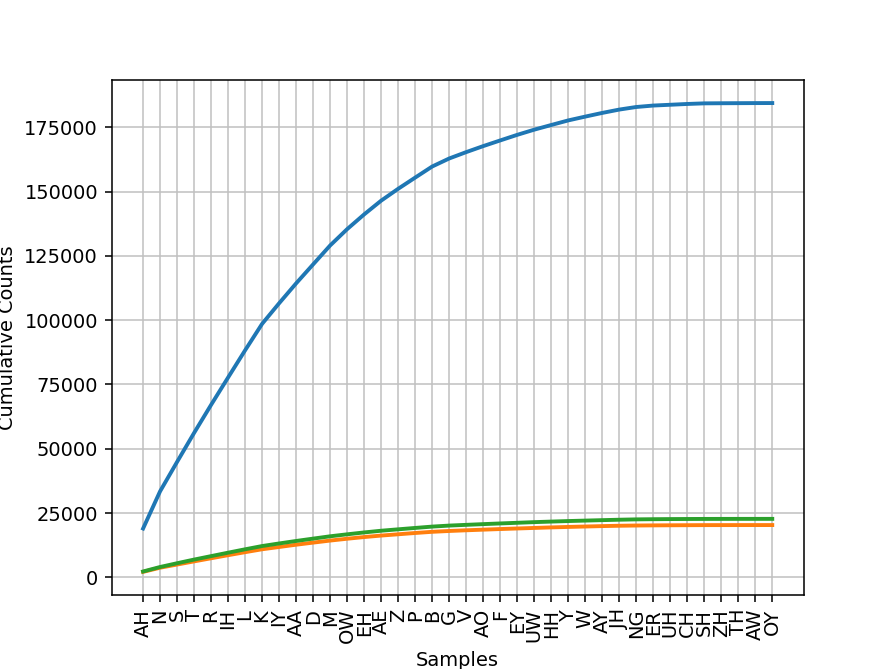

In [94]:
"""Plot tags on all sets"""
t_dist.plot(38, cumulative=True)
e_dist.plot(38, cumulative=True)
test_dist.plot(38, cumulative=True)

As the training set is 90% of the data, test set in 10%, and evaluation set is a little less, the frequencies seem to be exactly as they should.

What comes to overfitting, I do not think there is much risk as the data is so varied (134,000 English words), and the data are pseudo-randomly divided so there should not be any idiosyncracies involved; apart of course from the fact that it only learns words that have the same amount of graphemes and phonemes.

First I will test the majority baseline approach to see how accurate a naive tagger will be. It will assign every grapheme with its most likely phoneme and tag the words accordingly.

In [95]:
def baseline(train_set, ref_set):
    from collections import Counter
    entries = cmudict.entries()
    
    # List of graphemes, in this case the alphabet as the program
    # only allows words where one letter represents one phone.
    graphemes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    freq_tags = []
    for grapheme in graphemes: # iterate graphemes
        tag_4_grapheme = []
        for item in train_set: # iterate training set for every grapheme-phone pair.
            for x,y in item:
                if x == grapheme:
                    tag_4_grapheme.append(y)
        
        # all phones in training set that correspond to the grapheme in
        # our reference "graphemes" list are appended to freq_tags.
        freq_tags.append(tag_4_grapheme)

    most_freq_tags = []
    
    for grapheme in freq_tags:
        count = Counter(grapheme) # count all instances of indiviual phones.
        most_freq_tags.append(count.most_common(1)) # find most frequent phone for that grapheme
    just_tags = []
    for i in most_freq_tags:
        just_tags.append([x for (x,y) in i]) # take only the phones from the most frequent list.
    just_tags = [y for x in just_tags for y in x]
    default_tags = zip(graphemes, just_tags) # Combine graphemes with their most common phonemes
    def_tags = {}
    for x, y in default_tags:
        def_tags[x] = y #make the list into a dictionary with graphemes as keys and phonemes as values
    default_tagged = []
    word_graphs = []
    for i in ref_set: #clean evaluation set from tags
        graphs = [x for x,y in i]
        word_graphs.append(graphs)
        
    for i in word_graphs:
        default_tagged_word = []
        for g in i:
            pair = (g, def_tags.get(g)) # assign the cleaned evaluation set with the most likely phone
                                        # for every grapheme.
            default_tagged_word.append(pair)
        default_tagged_word = tuple(default_tagged_word)
        default_tagged.append(default_tagged_word)
    
    count = 0
    lencount = 0
    count2 = 0
    lencount2 = 0
    for (x, y) in zip(default_tagged, ref_set): # Iterate the tagged set and evaluation set.
        lencount +=1  # counts number of words in the data
        if x == y:    # checks if the tag is correct
            count +=1 # counts correct taggings
        for a,b in zip(x,y): # iterates graphemes in words
            lencount2 +=1    # counts graphemes
            if a == b:       # checks if tag is correct on grapheme level
                count2 +=1   # counts correct grapheme-phoneme pairs
                
    print("Accuracy of majority baseline on whole words:", count/lencount)
    print("Accuracy of majority baseline on graphemes:", count2/lencount2)
    
print("Baseline on evaluation set:\n")
baseline(train_set, evaluation_set)
print()
print("Baseline on test set:\n")
baseline(train_set, test_set)

Baseline on evaluation set:

Accuracy of majority baseline on whole words: 0.12495932313699967
Accuracy of majority baseline on graphemes: 0.7031426744700733

Baseline on test set:

Accuracy of majority baseline on whole words: 0.1195079086115993
Accuracy of majority baseline on graphemes: 0.6993624972521433


The accuracy of the baseline approach on the test set is ~12.0% on whole words and ~70.0% on individual graphemes. It is quite a low probably. This might be because of the salience of loan words, as well as English having had major changes in pronunciation since the standardization of its ortography, e.g. the great vowel shift. It would be interesting to see how well this would perform with Finnish – probably much better as Finnish has much more of a phonetic ortography.

Next, I will implement the Hidden Markov Model. Originally, the accuracy of the model was around 14% and 68%, so pretty much useless if the same results can be obtained with merely assigning the most likely tag for every grapheme. Also, adding OOV "words" would not work as the grapheme and phoneme sets are so small that there are no rare "words."

Apart from suprasegmental features like stress and focus, phenomena around pronunciation are quite local, most likely the closest phonemes affecting the most. Also, in the English language, pronunciation of a grapheme can be dependent on where it is located within a word. Thus, I chose to implement START and END states on the training data for the HMM algorithm to take into account. Let's see how it performs now:

In [96]:
"""This adds the <START> and <END> tags on words."""
def states(ref_set):
    r_set = []
    for i in ref_set:
        i_word = []
        i_word.append(("","<START>"))
        for item in i:
            i_word.append(item)
        i_word.append(("","<END>"))
        r_set.append(tuple(i_word))
    return r_set


def hmm():
    
    from nltk import hmm
    global tagger
    trainer = hmm.HiddenMarkovModelTrainer(states=["<START>","<END>"])
    t_set = states(train_set)
    
    tagger = trainer.train_supervised(t_set)
hmm()

"""Untags a given data set and then uses a tagger to tag it."""
def tag_words(ref_set, tagger):
        untag = []
        for i in ref_set:
            untag.append([x for x,y in i])
        tagged = [tagger.tag(list(i)) for i in untag]
        return tagged
    
"""Evaluates the accuracy of a tagger similarly as earlier in the baseline approach."""
def evaluate(eval_hmm, ref_set):
    eval_hmm = [tuple(i) for i in eval_hmm]
    count = 0 #counts correct words taggings
    lencount = 0 #counts words
    count2 = 0 #counts correct grapheme taggings
    lencount2 = 0 #counts graphemes
    for (x, y) in zip(eval_hmm, ref_set): # Iterate tagged set to the gold standard.
        lencount +=1
        if x == y:
            count +=1
        for a,b in zip(x,y):
            lencount2 +=1
            if a == b:
                count2 +=1
    print("Accuracy of tagger on whole words:", count/lencount)
    print("Accuracy of tagger on graphemes:", count2/lencount2)

eval_states = states(evaluation_set)
test_states = states(test_set)
print("HMM on evaluation set:")
evaluate(tag_words(eval_states, tagger), states(evaluation_set))
print("HMM on test set:")
evaluate(tag_words(test_states, tagger), states(test_set))
    


HMM on evaluation set:
Accuracy of tagger on whole words: 0.26846729580214773
Accuracy of tagger on graphemes: 0.825824238075456
HMM on test set:
Accuracy of tagger on whole words: 0.24809607498535444
Accuracy of tagger on graphemes: 0.8194298853684103


The start and end state tags have improved the accuracy somewhat significantly, performing constantly at 23-25% on whole words and 81-82% on graphemes when tagging the test set.

Next, I will implement different n-gram taggers:

In [97]:
def n_gram(input_set):

    # Train and test different tagger configurations

    t0 = nltk.DefaultTagger('AH')

    print("Default tagger:")
    print(evaluate(tag_words(input_set, t0), input_set))

    t1 = nltk.UnigramTagger(train_set)
    print("Unigram tagger:")
    print(evaluate(tag_words(input_set, t1), input_set))

    t2 = nltk.BigramTagger(train_set)
    print("Bigram tagger:")
    print(evaluate(tag_words(input_set, t2), input_set))

    t3 = nltk.TrigramTagger(train_set)
    print("Trigram tagger:")
    print(evaluate(tag_words(input_set, t3), input_set))

    t1bo = nltk.UnigramTagger(train_set, backoff=t0)
    print("Unigram tagger with backoff:")
    print(evaluate(tag_words(input_set, t1bo), input_set))

    t2bo = nltk.BigramTagger(train_set, backoff=t1bo)
    print("Bigram tagger with backoff:")
    print(evaluate(tag_words(input_set, t2bo), input_set))

    t3bo = nltk.TrigramTagger(train_set, backoff=t2bo)
    print("Trigram tagger with backoff:")
    print(evaluate(tag_words(input_set, t3bo), input_set))

    t1boco = nltk.UnigramTagger(train_set, backoff=t0, cutoff=1)
    print("Unigram tagger with back- and cutoff:")
    print(evaluate(tag_words(input_set, t1boco), input_set))

    t2boco = nltk.BigramTagger(train_set, backoff=t1boco, cutoff=1)
    print("Bigram tagger with back- and cutoff:")
    print(evaluate(tag_words(input_set, t2boco), input_set))

    t3boco = nltk.TrigramTagger(train_set, backoff=t2boco, cutoff=1)
    print("Trigram tagger with back- and cutoff:")
    print(evaluate(tag_words(input_set, t3boco), input_set))
n_gram(evaluation_set)

Default tagger:
Accuracy of tagger on whole words: 0.0
Accuracy of tagger on graphemes: 0.10470663453499238
None
Unigram tagger:
Accuracy of tagger on whole words: 0.12561015294500488
Accuracy of tagger on graphemes: 0.7037328480794767
None
Bigram tagger:
Accuracy of tagger on whole words: 0.14123006833712984
Accuracy of tagger on graphemes: 0.6955195986819456
None
Trigram tagger:
Accuracy of tagger on whole words: 0.19850309144158804
Accuracy of tagger on graphemes: 0.6396990114592043
None
Unigram tagger with backoff:
Accuracy of tagger on whole words: 0.12561015294500488
Accuracy of tagger on graphemes: 0.7037328480794767
None
Bigram tagger with backoff:
Accuracy of tagger on whole words: 0.14188089814513505
Accuracy of tagger on graphemes: 0.7001426252889391
None
Trigram tagger with backoff:
Accuracy of tagger on whole words: 0.20403514480963228
Accuracy of tagger on graphemes: 0.7122411842817096
None
Unigram tagger with back- and cutoff:
Accuracy of tagger on whole words: 0.1256101

The best results seem to come with the trigram tagger with backoff and cutoff. Let's evaluate it on the test set:

(I'm not sure why the code prints "None" values after the evaluation. But in any case the results are consistent with the results of the NLTK library's evaluator at the beginning when I started, so it should only be a cosmetic nuisance.)

In [98]:
t0 = nltk.DefaultTagger('AH')
t1 = nltk.UnigramTagger(train_set)
t2 = nltk.BigramTagger(train_set)
t3 = nltk.TrigramTagger(train_set)
t1bo = nltk.UnigramTagger(train_set, backoff=t0)
t2bo = nltk.BigramTagger(train_set, backoff=t1bo)
t3bo = nltk.TrigramTagger(train_set, backoff=t2bo)
t1boco = nltk.UnigramTagger(train_set, backoff=t0, cutoff=1)
t2boco = nltk.BigramTagger(train_set, backoff=t1boco, cutoff=1)
t3boco = nltk.TrigramTagger(train_set, backoff=t2boco, cutoff=1)
print("Trigram tagger with back- and cutoff:")
print(evaluate(tag_words(test_set, t3boco), test_set))

Trigram tagger with back- and cutoff:
Accuracy of tagger on whole words: 0.19625073227885179
Accuracy of tagger on graphemes: 0.7089909870301165
None


The trigram tagger with cutoff and backoff scores 19.6%/71.1% on the test set. It is definitely better than the baseline approach on whole words but similar on individual graphemes.
Still, the HMM tagger clearly is the best at just above 23%/80% on the test set.

I was surprised that even the HMM tagger fares so poorly on whole words, but it seems English pronunciation really is as rife with inconsistensies as its reputation states. In the future, it would be interesting to have data tagged with etymology to see if the algorithm would be better at predicting pronunciation for words with Germanic roots. Although it is an attractive presupposition, it might not be correct as Latin and French loan words also follow an internal logic, and one might actually find more relevant change in pronunciation post-15th Century when printing was introduced to the UK, e.g. the already mentioned Great Vowel Shift.

To answer the questions from the beginning of the paper, HMM is significantly better than baseline and n-gram approaches, so even if this implementation did not yield a highly reliable tagger, its results show promise and hint that HMMs are very much suitable for this task. What comes to hidden structures, it is seems clear that, as hypothesised earlier, a grapheme's location within a word will have an effect on its pronunciation.

As it is now, even the HMM tagger would not be a sufficiently reliable transcriber for something like a speech synthesizer even though it might be semi-intelligible. I am not sure how synthesizers tackle these problems, but if a synthesizer would have a list of words that it knows how to pronounce, this algorithm could be helpful in finding a correct pronunciation for those words that aren't listed, e.g. slang words, words with typos, etc. Apart from this, it was interesting to see that even a simple, or at least easy to implement, machine learning algorithm can unearth contextual phenomena around pronunciation.